# 1. Imports

In [1]:
import json
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from tensorboard.backend.event_processing import event_accumulator
%matplotlib inline

# 2. Utility Functions

## Loading Custom Data

In [2]:
def load_custom_data(json_path, algorithm_name, duration, color, algorithm_type):
    """
    Load custom implementation data from a JSON file.
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame({
        'Algorithm Name': [algorithm_name],
        'Duration': [duration],
        'Type': [algorithm_type],
        'Color': [color],
        'Episode Rewards': [data.get('Episode Rewards', [])],
        'Episode Times': [data.get('Episode Times', [])],
        'Episode Timesteps': [None],  # Placeholder
        'Losses': [data.get('Losses', [])],
        'Loss Times': [data.get('Loss Times', [])],
        'Loss Timesteps': [None],  # Placeholder
        'Total Training Time': [data.get('Total Training Time', None)],
        'Total Episodes': [data.get('Total Episodes', None)],
        'Average Timesteps per Episode': [data.get('Timesteps per Episode', [])],
        'Mean Evaluation Reward': [data.get('Mean Evaluation Reward', None)],
        'Std Evaluation Reward': [data.get('Std Evaluation Reward', None)]
    })
    return df

## Loading SB3 Data

In [3]:
def load_sb3_data(tensorboard_log_dir, json_path, algorithm_name, duration, color, algorithm_type, n_envs=8):
    """
    Load SB3 implementation data from TensorBoard logs.
    Calculates the total training time across multiple event files by using the min and max timestamps.
    Adjusts total training time to match expected duration if within a tolerance of 1 minute.
    Adds wall times for each episode reward as Episode Times.
    Calculates the total number of executed episodes based on the number of environments.
    
    Parameters:
    - tensorboard_log_dir (str): Path to the TensorBoard log directory.
    - json_path (str): Path to the JSON file containing evaluation data and configuration.
    - algorithm_name (str): Name of the algorithm (e.g., 'PPO').
    - duration (str): Expected duration of training (e.g., '3h', '6h', '9h').
    - color (str): Color code or identifier for visualization purposes.
    - algorithm_type (str): Type of algorithm (e.g., 'policy_gradient').
    - n_envs (int): Number of parallel environments used during training (default is 8).
    
    Returns:
    - pd.DataFrame: DataFrame containing the aggregated training metrics.
    """
    # Define expected durations in seconds
    duration_map = {'3h': 3 * 3600, '6h': 6 * 3600, '9h': 9 * 3600}
    expected_duration = duration_map.get(duration, None)

    # Find all event files in the TensorBoard log directory
    event_files = glob.glob(os.path.join(tensorboard_log_dir, '**', 'events.*'), recursive=True)
    
    # Initialize lists to store metrics
    rewards = []
    rewards_timesteps = []
    rewards_times = []  # To store wall times for episode rewards
    losses = []
    losses_timesteps = []
    all_timestamps = []

    # Load evaluation data from JSON
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Process each event file to extract relevant metrics and timestamps
    for event_file in event_files:
        ea = event_accumulator.EventAccumulator(event_file)
        ea.Reload()

        # Rewards
        if 'rollout/ep_rew_mean' in ea.Tags().get('scalars', []):
            events = ea.Scalars('rollout/ep_rew_mean')
            rewards.extend([e.value for e in events])
            rewards_timesteps.extend([e.step for e in events])
            rewards_times.extend([e.wall_time for e in events])  # Collect wall times for rewards
            all_timestamps.extend([e.wall_time for e in events])

        # Losses
        if 'train/loss' in ea.Tags().get('scalars', []):
            events = ea.Scalars('train/loss')
            losses.extend([e.value for e in events])
            losses_timesteps.extend([e.step for e in events])
            all_timestamps.extend([e.wall_time for e in events])

    # Calculate total training time using the earliest and latest timestamps across all files
    if all_timestamps:
        calculated_training_time = max(all_timestamps) - min(all_timestamps)
        # Adjust training time to match expected duration if within tolerance
        if expected_duration and abs(calculated_training_time - expected_duration) <= 60:
            total_training_time = expected_duration  # Use expected duration if close enough
        else:
            total_training_time = calculated_training_time  # Use calculated time otherwise
    else:
        total_training_time = None

    # Calculate average timesteps per episode
    if len(rewards_timesteps) > 1:
        diffs = np.diff(rewards_timesteps)
        avg_timesteps = np.mean(diffs).tolist()
    else:
        avg_timesteps = []

    # Calculate total episodes
    total_episodes = len(rewards) * n_envs

    # Create DataFrame
    df = pd.DataFrame({
        'Algorithm Name': [algorithm_name],
        'Duration': [duration],
        'Type': [algorithm_type],
        'Color': [color],
        'Episode Rewards': [rewards],
        'Episode Times': [rewards_times],
        'Episode Timesteps': [rewards_timesteps],
        'Losses': [losses],
        'Loss Times': [None],  # Keeping Loss Times empty for now
        'Loss Timesteps': [losses_timesteps],
        'Total Training Time': [total_training_time],
        'Total Episodes': [total_episodes],
        'Average Timesteps per Episode': [avg_timesteps],
        'Mean Evaluation Reward': [data.get('mean_reward', None)],
        'Std Evaluation Reward': [data.get('std_reward', None)]
    })

    return df

# 3. Fetch and Load Model Data

## Algorithm Specifications

In [4]:
# Initialize an empty list to hold all dataframes
dfs = []

# Specify the 6h algorithms you want to load
algorithms = [
    # Custom Implementations
    {'type': 'custom', 'name': 'DQN_Custom', 'json_path': './metrics/custom_6h/dqn_custom_metrics_PongNoFrameskip-v4_21600.json', 'duration': '6h', 'color': '#1E88E5'},
    {'type': 'custom', 'name': 'A2C_Custom', 'json_path': './metrics/custom_6h/a2c_custom_metrics_PongNoFrameskip-v4_21600.json', 'duration': '6h', 'color': '#E53935'},
    {'type': 'custom', 'name': 'PPO_Custom', 'json_path': './metrics/custom_6h/ppo_custom_metrics_PongNoFrameskip-v4_21600.json', 'duration': '6h', 'color': '#43A047'},
    
    # SB3 Implementations
    {'type': 'sb3', 'name': 'DQN_SB3', 'log_dir': './sb3_logs/DQN_PongNoFrameskip-v4_21600/', 'json_path': './metrics/sb3_eval/dqn_model_21600/metrics.json', 'duration': '6h', 'color': '#00ACC1'}, 
    {'type': 'sb3', 'name': 'A2C_SB3', 'log_dir': './sb3_logs/A2C_PongNoFrameskip-v4_21600/', 'json_path': './metrics/sb3_eval/a2c_model_21600/metrics.json', 'duration': '6h', 'color': '#EC407A'},
    {'type': 'sb3', 'name': 'PPO_SB3', 'log_dir': './sb3_logs/PPO_PongNoFrameskip-v4_21600/', 'json_path': './metrics/sb3_eval/ppo_model_21600/metrics.json', 'duration': '6h', 'color': '#7CB342'},
]

## Load Data for each Algorithm

In [5]:
# Load data for each algorithm
for algo in algorithms:
    if algo['type'] == 'custom':
        df = load_custom_data(
            json_path=algo['json_path'], 
            algorithm_name=algo['name'], 
            duration=algo['duration'], 
            color=algo['color'], 
            algorithm_type='Custom'
        )
    elif algo['type'] == 'sb3':
        df = load_sb3_data(
            tensorboard_log_dir=algo['log_dir'], 
            json_path=algo['json_path'],
            algorithm_name=algo['name'], 
            duration=algo['duration'], 
            color=algo['color'], 
            algorithm_type='SB3'
        )
    dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
data = pd.concat(dfs, ignore_index=True)

# Display the loaded data
data.head(6)

,Algorithm Name,Duration,Type,Color,Episode Rewards,Episode Times,Episode Timesteps,Losses,Loss Times,Loss Timesteps,Total Training Time,Total Episodes,Average Timesteps per Episode,Mean Evaluation Reward,Std Evaluation Reward
0,DQN_Custom,6h,Custom,#1E88E5,"[-20.0, -20.0, -20.0, -19.0, -21.0, -21.0, -21...","[0.4292600154876709, 0.9215259552001953, 1.339...",None,"[0.030733944848179817, 0.02990429475903511, 0....","[24.076017141342163, 24.136537075042725, 24.19...",None,21600.052597,802,1841.062344,20.1,0.300000
1,A2C_Custom,6h,Custom,#E53935,"[-21.0, -20.0, -20.0, -21.0, -21.0, -19.0, -20...","[7.131662845611572, 7.188999891281128, 7.19832...",None,"[0.005728051066398621, 38.598167419433594, 0.0...","[0.989703893661499, 2.1485397815704346, 3.3346...",None,21600.763753,9896,1866.192401,20.9,0.300000
2,PPO_Custom,6h,Custom,#43A047,"[-21.0, -20.0, -21.0, -20.0, -21.0, -21.0, -20...","[23.029888153076172, 23.057080030441284, 23.14...",None,"[0.04650283604860306, 0.5804498195648193, 0.36...","[0.5043368339538574, 0.769935131072998, 0.9976...",None,21600.968379,2917,2023.075763,19.7,1.345362
3,DQN_SB3,6h,SB3,#00ACC1,"[-20.0, -20.25, -20.16666603088379, -20.125, -...","[1729188916.879576, 1729188918.6085691, 172918...","[3663, 7195, 10965, 14748, 18723, 22394, 25776...","[0.03014424443244934, 0.029722383245825768, 0....",None,"[52093, 56075, 59708, 63060, 66608, 70189, 740...",21534.592670,2800,6606.409742,7.3,8.866228
4,A2C_SB3,6h,SB3,#EC407A,"[-20.260000228881836, -20.030000686645508, -20...","[1729232239.753669, 1729232330.480791, 1729232...","[102400, 204800, 307200, 409600, 512000, 61440...",[],None,[],21484.498694,1944,102400.000000,21.0,0.000000
5,PPO_SB3,6h,SB3,#7CB342,"[-20.66666603088379, -20.33333396911621, -20.0...","[1729210551.016499, 1729210553.675305, 1729210...","[7168, 8192, 9216, 10240, 11264, 12288, 13312,...","[0.019096875563263893, 0.04591640830039978, 0....",None,"[2048, 3072, 4096, 5120, 6144, 7168, 8192, 921...",21600.000000,63848,1024.000000,21.0,0.000000


# 4. Enrich and Preprocess Data

## Preprocess Data

In [6]:
def preprocess_data(data):
    """
    Preprocess the data to handle missing values and convert data types.
    """
    # Convert numeric columns to numeric data types
    numeric_columns = ['Total Training Time', 'Total Episodes', 
                       'Mean Evaluation Reward', 'Std Evaluation Reward']
    for col in numeric_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    
    # Handle missing values for columns that should contain lists
    list_columns = ['Episode Rewards', 'Episode Times', 'Episode Timesteps', 
                   'Losses', 'Loss Times', 'Loss Timesteps']
    for col in list_columns:
        data[col] = data[col].apply(lambda x: x if isinstance(x, list) else [])
    
    def compute_total_steps(row):
        if row['Type'] == 'Custom':
            # Compute average timesteps per episode as the mean
            if row['Average Timesteps per Episode']:
                avg_timesteps = np.mean(row['Average Timesteps per Episode'])
                if not np.isnan(avg_timesteps) and not np.isnan(row['Total Episodes']):
                    return avg_timesteps * row['Total Episodes']
                else:
                    return np.nan
            else:
                return np.nan
        elif row['Type'] == 'SB3':
            if row['Episode Timesteps']:
                return row['Episode Timesteps'][-1]
            else:
                return np.nan
        else:
            return np.nan
    
    data['Total Steps'] = data.apply(compute_total_steps, axis=1)
    
    return data

# Apply preprocessing
data = preprocess_data(data)

# Display the preprocessed data
data.head(6)

,Algorithm Name,Duration,Type,Color,Episode Rewards,Episode Times,Episode Timesteps,Losses,Loss Times,Loss Timesteps,Total Training Time,Total Episodes,Average Timesteps per Episode,Mean Evaluation Reward,Std Evaluation Reward,Total Steps
0,DQN_Custom,6h,Custom,#1E88E5,"[-20.0, -20.0, -20.0, -19.0, -21.0, -21.0, -21...","[0.4292600154876709, 0.9215259552001953, 1.339...",[],"[0.030733944848179817, 0.02990429475903511, 0....","[24.076017141342163, 24.136537075042725, 24.19...",[],21600.052597,802,1841.062344,20.1,0.300000,1476532.0
1,A2C_Custom,6h,Custom,#E53935,"[-21.0, -20.0, -20.0, -21.0, -21.0, -19.0, -20...","[7.131662845611572, 7.188999891281128, 7.19832...",[],"[0.005728051066398621, 38.598167419433594, 0.0...","[0.989703893661499, 2.1485397815704346, 3.3346...",[],21600.763753,9896,1866.192401,20.9,0.300000,18467840.0
2,PPO_Custom,6h,Custom,#43A047,"[-21.0, -20.0, -21.0, -20.0, -21.0, -21.0, -20...","[23.029888153076172, 23.057080030441284, 23.14...",[],"[0.04650283604860306, 0.5804498195648193, 0.36...","[0.5043368339538574, 0.769935131072998, 0.9976...",[],21600.968379,2917,2023.075763,19.7,1.345362,5901312.0
3,DQN_SB3,6h,SB3,#00ACC1,"[-20.0, -20.25, -20.16666603088379, -20.125, -...","[1729188916.879576, 1729188918.6085691, 172918...","[3663, 7195, 10965, 14748, 18723, 22394, 25776...","[0.03014424443244934, 0.029722383245825768, 0....",[],"[52093, 56075, 59708, 63060, 66608, 70189, 740...",21534.592670,2800,6606.409742,7.3,8.866228,2309300.0
4,A2C_SB3,6h,SB3,#EC407A,"[-20.260000228881836, -20.030000686645508, -20...","[1729232239.753669, 1729232330.480791, 1729232...","[102400, 204800, 307200, 409600, 512000, 61440...",[],[],[],21484.498694,1944,102400.000000,21.0,0.000000,24883200.0
5,PPO_SB3,6h,SB3,#7CB342,"[-20.66666603088379, -20.33333396911621, -20.0...","[1729210551.016499, 1729210553.675305, 1729210...","[7168, 8192, 9216, 10240, 11264, 12288, 13312,...","[0.019096875563263893, 0.04591640830039978, 0....",[],"[2048, 3072, 4096, 5120, 6144, 7168, 8192, 921...",21600.000000,63848,1024.000000,21.0,0.000000,8178688.0


## Add Threshold Columns

In [7]:
def find_threshold_episode(episode_rewards, threshold, consecutive=5):
    """
    Find the first episode where 'consecutive' number of episodes have rewards >= threshold.
    
    Parameters:
    - episode_rewards (list or np.array): List of rewards per episode.
    - threshold (float): Reward threshold to exceed.
    - consecutive (int): Number of consecutive episodes required.
    
    Returns:
    - int: Episode number where the threshold is first passed with the required consecutive episodes.
           Returns np.nan if the threshold is never reached.
    """
    count = 0
    for idx, reward in enumerate(episode_rewards):
        if reward >= threshold:
            count += 1
            if count == consecutive:
                return idx + 1  # Episode numbers start at 1
        else:
            count = 0
    return np.nan  # Threshold not reached

def add_threshold_columns(data, thresholds):
    """
    Add 'Threshold Episode' and 'Threshold Timestep' columns to the DataFrame based on consecutive episodes.
    
    Parameters:
    - data (pd.DataFrame): The preprocessed DataFrame containing algorithm data.
    - thresholds (list): A list of reward thresholds to monitor.
    
    Returns:
    - pd.DataFrame: The DataFrame with added threshold columns.
    """
    threshold_episode_list = []
    threshold_timestep_list = []
    threshold_times_list = []
    
    for index, row in data.iterrows():
        episode_rewards = row['Episode Rewards']
        algorithm_type = row['Type']
        
        # Set consecutive episodes based on algorithm type
        if algorithm_type == 'Custom':
            consecutive = 8
        elif algorithm_type == 'SB3':
            consecutive = 1
        else:
            consecutive = 5  # Default value if needed
        
        threshold_episode = {}
        threshold_timestep = {}
        threshold_times = {}
        
        for threshold in thresholds:
            # Find the first episode where 'consecutive' episodes have rewards >= threshold
            episode_num = find_threshold_episode(episode_rewards, threshold, consecutive)
            threshold_episode[threshold] = episode_num
            
            # Handle timesteps based on algorithm type
            if algorithm_type == 'SB3' and not np.isnan(episode_num):
                episode_timesteps = row['Episode Timesteps']
                # For SB3, the timestep corresponding to the first episode in the sequence
                first_episode_idx = episode_num - 1  # Zero-based index
                if episode_timesteps and len(episode_timesteps) > first_episode_idx:
                    threshold_timestep[threshold] = episode_timesteps[first_episode_idx]
                else:
                    threshold_timestep[threshold] = np.nan  # Handle missing timesteps
            elif algorithm_type == 'Custom' and not np.isnan(episode_num):
                episode_times = row['Episode Times']
                # For Custom, the time corresponding to the last episode in the consecutive sequence
                last_episode_idx = episode_num - 1  # Zero-based index
                if episode_times and len(episode_times) > last_episode_idx:
                    threshold_times[threshold] = episode_times[last_episode_idx]
                else:
                    threshold_times[threshold] = np.nan  # Handle missing times
            else:
                threshold_timestep[threshold] = np.nan  # Threshold not reached or not applicable
                threshold_times[threshold] = np.nan  # Threshold not reached or not applicable
        
        threshold_episode_list.append(threshold_episode)
        threshold_timestep_list.append(threshold_timestep)
        threshold_times_list.append(threshold_times)
    
    # Add new columns to the DataFrame
    data['Threshold Episode'] = threshold_episode_list
    data['Threshold Timestep'] = threshold_timestep_list
    data['Threshold Times'] = threshold_times_list
    
    return data
    return data

# Add the new columns
thresholds = [0, 10, 21]
data = add_threshold_columns(data, thresholds)

# Display the updated DataFrame
data.head(6)

,Algorithm Name,Duration,Type,Color,Episode Rewards,Episode Times,Episode Timesteps,Losses,Loss Times,Loss Timesteps,Total Training Time,Total Episodes,Average Timesteps per Episode,Mean Evaluation Reward,Std Evaluation Reward,Total Steps,Threshold Episode,Threshold Timestep,Threshold Times
0,DQN_Custom,6h,Custom,#1E88E5,"[-20.0, -20.0, -20.0, -19.0, -21.0, -21.0, -21...","[0.4292600154876709, 0.9215259552001953, 1.339...",[],"[0.030733944848179817, 0.02990429475903511, 0....","[24.076017141342163, 24.136537075042725, 24.19...",[],21600.052597,802,1841.062344,20.1,0.300000,1476532.0,"{0: 686, 10: 788, 21: nan}",{21: nan},"{0: 16427.04087114334, 10: 21119.933355093002,..."
1,A2C_Custom,6h,Custom,#E53935,"[-21.0, -20.0, -20.0, -21.0, -21.0, -19.0, -20...","[7.131662845611572, 7.188999891281128, 7.19832...",[],"[0.005728051066398621, 38.598167419433594, 0.0...","[0.989703893661499, 2.1485397815704346, 3.3346...",[],21600.763753,9896,1866.192401,20.9,0.300000,18467840.0,"{0: 2844, 10: 2862, 21: 6765}",{},"{0: 4035.3577687740326, 10: 4085.6610407829285..."
2,PPO_Custom,6h,Custom,#43A047,"[-21.0, -20.0, -21.0, -20.0, -21.0, -21.0, -20...","[23.029888153076172, 23.057080030441284, 23.14...",[],"[0.04650283604860306, 0.5804498195648193, 0.36...","[0.5043368339538574, 0.769935131072998, 0.9976...",[],21600.968379,2917,2023.075763,19.7,1.345362,5901312.0,"{0: 882, 10: 960, 21: nan}",{21: nan},"{0: 4994.933825016022, 10: 5951.496952056885, ..."
3,DQN_SB3,6h,SB3,#00ACC1,"[-20.0, -20.25, -20.16666603088379, -20.125, -...","[1729188916.879576, 1729188918.6085691, 172918...","[3663, 7195, 10965, 14748, 18723, 22394, 25776...","[0.03014424443244934, 0.029722383245825768, 0....",[],"[52093, 56075, 59708, 63060, 66608, 70189, 740...",21534.592670,2800,6606.409742,7.3,8.866228,2309300.0,"{0: nan, 10: nan, 21: nan}","{0: nan, 10: nan, 21: nan}","{0: nan, 10: nan, 21: nan}"
4,A2C_SB3,6h,SB3,#EC407A,"[-20.260000228881836, -20.030000686645508, -20...","[1729232239.753669, 1729232330.480791, 1729232...","[102400, 204800, 307200, 409600, 512000, 61440...",[],[],[],21484.498694,1944,102400.000000,21.0,0.000000,24883200.0,"{0: 43, 10: 53, 21: nan}","{0: 4403200, 10: 5427200, 21: nan}",{21: nan}
5,PPO_SB3,6h,SB3,#7CB342,"[-20.66666603088379, -20.33333396911621, -20.0...","[1729210551.016499, 1729210553.675305, 1729210...","[7168, 8192, 9216, 10240, 11264, 12288, 13312,...","[0.019096875563263893, 0.04591640830039978, 0....",[],"[2048, 3072, 4096, 5120, 6144, 7168, 8192, 921...",21600.000000,63848,1024.000000,21.0,0.000000,8178688.0,"{0: 1426, 10: 1926, 21: nan}","{0: 1466368, 10: 1978368, 21: nan}",{21: nan}


In [8]:
def format_threshold_dict(threshold_dict):
    """
    Format the threshold dictionary into a readable string.
    
    Parameters:
    - threshold_dict (dict): Dictionary mapping thresholds to episode/timestep numbers.
    
    Returns:
    - str: Formatted string.
    """
    if not isinstance(threshold_dict, dict):
        return 'N/A'
    formatted = ', '.join([f"{k}: {v}" for k, v in threshold_dict.items() if not np.isnan(v)])
    return formatted if formatted else 'N/A'

# 5. Adjust Episode Timesteps across Batches
For SB3 implementations, timesteps may reset across batches. This function ensures that timesteps are cumulative

In [9]:
def adjust_episode_timesteps_across_batches(data):
    """
    Adjust the Episode Timesteps to account for batches where timesteps reset.
    Whenever a decrease is detected in the timesteps, it indicates a new batch.
    The function adjusts the timesteps to make them cumulative across batches.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the algorithm data.

    Returns:
    - pd.DataFrame: The DataFrame with the adjusted 'Episode Timesteps'.
    """
    data_adjusted = data.copy()

    for index, row in data_adjusted.iterrows():
        algorithm_name = row['Algorithm Name']
        episode_timesteps = row['Episode Timesteps']
        episode_rewards = row['Episode Rewards']

        if not episode_timesteps:
            continue 

        corrected_timesteps = []
        cumsum = 0 

        for i in range(len(episode_timesteps)):
            current_timestep = episode_timesteps[i]

            if i == 0:
                # First timestep; no adjustment needed
                corrected_timesteps.append(current_timestep)
            else:
                previous_timestep = episode_timesteps[i - 1]

                if current_timestep >= previous_timestep:
                    # Same batch; adjust with current cumsum
                    corrected_timesteps.append(current_timestep + cumsum)
                else:
                    # New batch detected
                    cumsum += previous_timestep
                    print(f"Algorithm {algorithm_name}: New batch detected at index {i}.")
                    print(f"Cumulative sum updated to {cumsum}.")

                    corrected_timesteps.append(current_timestep + cumsum)

        # Update the adjusted timesteps in the DataFrame
        data_adjusted.at[index, 'Episode Timesteps'] = corrected_timesteps
        data_adjusted.at[index, 'Total Steps'] = corrected_timesteps[-1]

        print(f"\nAlgorithm {algorithm_name} timesteps adjusted across batches.")
        print(f"Original timesteps: {episode_timesteps}")
        print(f"Adjusted timesteps: {corrected_timesteps}\n")

    return data_adjusted

data = adjust_episode_timesteps_across_batches(data)
data.head()


Algorithm DQN_SB3 timesteps adjusted across batches.
Original timesteps: [3663, 7195, 10965, 14748, 18723, 22394, 25776, 29393, 33215, 37090, 40874, 44878, 48320, 52093, 56075, 59708, 63060, 66608, 70189, 74043, 77796, 81118, 84766, 88544, 92359, 96140, 100295, 104382, 107913, 111376, 114901, 118976, 122417, 125987, 129517, 133095, 136704, 140565, 144088, 147929, 151529, 155714, 159382, 163011, 166583, 170617, 174391, 178013, 181705, 185227, 188927, 192902, 196553, 200122, 203912, 207646, 211600, 215429, 219594, 223515, 227592, 231784, 235878, 240374, 244377, 248687, 252457, 256197, 260516, 264752, 268421, 272907, 277954, 282857, 287668, 292723, 297311, 302081, 306813, 311324, 316310, 320658, 324800, 329765, 334196, 338744, 343431, 348289, 352872, 357954, 362757, 367737, 372058, 377356, 382434, 387665, 392641, 397777, 403012, 407927, 413395, 418893, 424348, 430046, 435113, 440792, 445766, 450433, 455842, 461033, 465989, 470990, 476938, 482555, 488531, 494543, 500215, 505642, 511041, 5

,Algorithm Name,Duration,Type,Color,Episode Rewards,Episode Times,Episode Timesteps,Losses,Loss Times,Loss Timesteps,Total Training Time,Total Episodes,Average Timesteps per Episode,Mean Evaluation Reward,Std Evaluation Reward,Total Steps,Threshold Episode,Threshold Timestep,Threshold Times
0,DQN_Custom,6h,Custom,#1E88E5,"[-20.0, -20.0, -20.0, -19.0, -21.0, -21.0, -21...","[0.4292600154876709, 0.9215259552001953, 1.339...",[],"[0.030733944848179817, 0.02990429475903511, 0....","[24.076017141342163, 24.136537075042725, 24.19...",[],21600.052597,802,1841.062344,20.1,0.300000,1476532.0,"{0: 686, 10: 788, 21: nan}",{21: nan},"{0: 16427.04087114334, 10: 21119.933355093002,..."
1,A2C_Custom,6h,Custom,#E53935,"[-21.0, -20.0, -20.0, -21.0, -21.0, -19.0, -20...","[7.131662845611572, 7.188999891281128, 7.19832...",[],"[0.005728051066398621, 38.598167419433594, 0.0...","[0.989703893661499, 2.1485397815704346, 3.3346...",[],21600.763753,9896,1866.192401,20.9,0.300000,18467840.0,"{0: 2844, 10: 2862, 21: 6765}",{},"{0: 4035.3577687740326, 10: 4085.6610407829285..."
2,PPO_Custom,6h,Custom,#43A047,"[-21.0, -20.0, -21.0, -20.0, -21.0, -21.0, -20...","[23.029888153076172, 23.057080030441284, 23.14...",[],"[0.04650283604860306, 0.5804498195648193, 0.36...","[0.5043368339538574, 0.769935131072998, 0.9976...",[],21600.968379,2917,2023.075763,19.7,1.345362,5901312.0,"{0: 882, 10: 960, 21: nan}",{21: nan},"{0: 4994.933825016022, 10: 5951.496952056885, ..."
3,DQN_SB3,6h,SB3,#00ACC1,"[-20.0, -20.25, -20.16666603088379, -20.125, -...","[1729188916.879576, 1729188918.6085691, 172918...","[3663, 7195, 10965, 14748, 18723, 22394, 25776...","[0.03014424443244934, 0.029722383245825768, 0....",[],"[52093, 56075, 59708, 63060, 66608, 70189, 740...",21534.592670,2800,6606.409742,7.3,8.866228,2309300.0,"{0: nan, 10: nan, 21: nan}","{0: nan, 10: nan, 21: nan}","{0: nan, 10: nan, 21: nan}"
4,A2C_SB3,6h,SB3,#EC407A,"[-20.260000228881836, -20.030000686645508, -20...","[1729232239.753669, 1729232330.480791, 1729232...","[102400, 204800, 307200, 409600, 512000, 61440...",[],[],[],21484.498694,1944,102400.000000,21.0,0.000000,24883200.0,"{0: 43, 10: 53, 21: nan}","{0: 4403200, 10: 5427200, 21: nan}",{21: nan}


In [10]:
def check_strictly_increasing(arr):
    return all(x < y for x, y in zip(arr, arr[1:]))

# Check the 'Episode Timesteps' column for strictly increasing arrays
for index, row in data.iterrows():
    episode_timesteps_adjusted = row['Episode Timesteps']
    if not check_strictly_increasing(episode_timesteps_adjusted):
        print(f"Array not strictly increasing at index {index} for algorithm {row['Algorithm Name']}")
    else:
        print(f"Array is strictly increasing at index {index} for algorithm {row['Algorithm Name']}")

Array is strictly increasing at index 0 for algorithm DQN_Custom
Array is strictly increasing at index 1 for algorithm A2C_Custom
Array is strictly increasing at index 2 for algorithm PPO_Custom
Array is strictly increasing at index 3 for algorithm DQN_SB3
Array is strictly increasing at index 4 for algorithm A2C_SB3
Array is strictly increasing at index 5 for algorithm PPO_SB3


# 6. Create Summary Tables

In [42]:
# Select summary columns, including the new threshold columns
summary_columns = [
    'Algorithm Name', 
    'Mean Evaluation Reward', 
    'Std Evaluation Reward', 
    'Total Steps', 
    'Total Episodes', 
    'Average Timesteps per Episode',
    'Threshold Episode', 
    'Threshold Timestep',
    'Threshold Times'
]
summary_df = data[summary_columns].copy()

# Format the threshold columns for better readability
summary_df['Threshold Episode'] = summary_df['Threshold Episode'].apply(format_threshold_dict)
summary_df['Threshold Timestep'] = summary_df['Threshold Timestep'].apply(format_threshold_dict)
summary_df['Threshold Times'] = summary_df['Threshold Times'].apply(format_threshold_dict)

# Rename columns for clarity
summary_df = summary_df.rename(columns={
    'Mean Evaluation Reward': 'Mean Eval Reward',
    'Std Evaluation Reward': 'Std Eval Reward'
})

# Handle missing data by replacing NaN with 'N/A'
summary_df = summary_df.fillna('N/A')

# Display the summary table with styling
def display_summary_table(df):
    """
    Display a styled summary table with highlights for better readability.
    """
    styled_df = df.style.set_properties(**{'text-align': 'center'}) \
                       .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]) \
                       .highlight_max(subset=['Mean Eval Reward'], color='lightgreen') \
                       .highlight_min(subset=['Mean Eval Reward'], color='lightcoral')
    display(styled_df)

# Display the summary table
display_summary_table(summary_df)

,Algorithm Name,Mean Eval Reward,Std Eval Reward,Total Steps,Total Episodes,Average Timesteps per Episode,Threshold Episode,Threshold Timestep,Threshold Times
0,DQN_Custom,20.100000,0.300000,1476532.000000,802,1841.062344,"0: 686, 10: 788",N/A,"0: 16427.04087114334, 10: 21119.933355093002"
1,A2C_Custom,20.900000,0.300000,18467840.000000,9896,1866.192401,"0: 2844, 10: 2862, 21: 6765",N/A,"0: 4035.3577687740326, 10: 4085.6610407829285, 21: 14081.852140903473"
2,PPO_Custom,19.700000,1.345362,5901312.000000,2917,2023.075763,"0: 882, 10: 960",N/A,"0: 4994.933825016022, 10: 5951.496952056885"
3,DQN_SB3,7.300000,8.866228,2309300.000000,2800,6606.409742,N/A,N/A,N/A
4,A2C_SB3,21.000000,0.000000,24883200.000000,1944,102400.000000,"0: 43, 10: 53","0: 4403200, 10: 5427200",N/A
5,PPO_SB3,21.000000,0.000000,8178688.000000,63848,1024.000000,"0: 1426, 10: 1926","0: 1466368, 10: 1978368",N/A


# 7. Visualizations

## Helper Functions for Plotting

In [197]:
# Helper Functions
def compute_smoothed_rewards(rewards, sigma=2):
    if not rewards:
        return np.array([])
    return gaussian_filter1d(rewards, sigma=sigma)

def add_labels(ax, fontsize=10, threshold=0.1):
    y_max = ax.get_ylim()[1]
    for p in ax.patches:
        height = p.get_height()
        if np.isnan(height):
            continue
        if height > threshold * y_max:
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height - 0.04 * y_max),
                        ha='center', va='top', color='white', fontsize=fontsize)
        else:
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height + 0.01 * y_max),
                        ha='center', va='bottom', color='black', fontsize=fontsize)

def reshape_threshold_data(data, column_prefix, thresholds):
    records = []
    for _, row in data.iterrows():
        algo = row['Algorithm Name']
        for threshold in thresholds:
            value = row[column_prefix].get(threshold, np.nan) if isinstance(row[column_prefix], dict) else np.nan
            if not np.isnan(value):
                records.append({
                    'Algorithm Name': algo,
                    'Threshold': threshold,
                    'Value': value
                })
    return pd.DataFrame(records)

# Plotting Functions
def plot_mean_evaluation_rewards(data, ax):
    sns.barplot(
        x='Algorithm Name',
        y='Mean Evaluation Reward',
        hue='Algorithm Name',
        data=data,
        palette=data['Color'].tolist(),
        edgecolor='black',
        errorbar=None,
        ax=ax
    )
    ax.errorbar(
        x=np.arange(len(data)),
        y=data['Mean Evaluation Reward'],
        yerr=data['Std Evaluation Reward'],
        fmt='none',
        c='black',
        capsize=5
    )
    ax.set_ylabel('Mean Evaluation Reward', fontweight='bold')
    ax.set_xlabel('')
    ax.set_title('Mean Evaluation Reward with Standard Deviation', fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
    plt.setp(ax.get_yticklabels(), fontweight='bold')
    add_labels(ax)

def plot_training_stability(data, window=10, ax=None):
    for _, row in data.iterrows():
        rewards = row['Episode Rewards']
        if not rewards:
            continue
        rolling_mean = pd.Series(rewards).rolling(window=window).mean()
        rolling_std = pd.Series(rewards).rolling(window=window).std()
        episodes = list(range(1, len(rolling_mean) + 1))
        if row['Type'] == 'SB3':
            episodes = [e * 8 for e in episodes]
        ax.plot(episodes, rolling_mean, color=row['Color'], label=row['Algorithm Name'], linewidth=2.5)
        ax.fill_between(episodes, rolling_mean - rolling_std, rolling_mean + rolling_std, color=row['Color'], alpha=0.2)
    ax.set_xlabel('Episode', fontweight='bold')
    ax.set_ylabel('Reward', fontweight='bold')
    ax.set_title('Training Stability (Rolling Mean & Std)', fontweight='bold')
    plt.setp(ax.get_yticklabels(), fontweight='bold')
    plt.setp(ax.get_xticklabels(), fontweight='bold')
    ax.legend()
    ax.set_ylim(-22, 22)

def plot_total_episodes(data, ax):
    sns.barplot(
        x='Algorithm Name',
        y='Total Episodes',
        hue='Algorithm Name',
        data=data,
        palette=data['Color'].tolist(),
        edgecolor='black',
        errorbar=None,
        ax=ax
    )
    ax.set_ylabel('Total Episodes', fontweight='bold')
    ax.set_xlabel('')
    ax.set_title('Total Episodes', fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
    plt.setp(ax.get_xticklabels(), fontweight='bold')
    add_labels(ax)

def plot_threshold_episodes_sb3(data, thresholds, ax=None):
    """
    Plot timesteps needed to reach each threshold for SB3 algorithms.
    """
    threshold_df = reshape_threshold_data(data, 'Threshold Timestep', thresholds)
    if threshold_df.empty:
        print("No threshold data available for SB3 algorithms.")
        return
    sns.barplot(
        x='Algorithm Name',
        y='Value',
        hue='Threshold',
        data=threshold_df,
        palette='viridis',
        edgecolor='black',
        ax=ax
    )
    ax.set_ylabel('Timesteps to Reach Threshold', fontweight='bold')
    ax.set_xlabel('')
    ax.set_title('Timesteps at Thresholds (SB3)', fontweight='bold')
    ax.legend(title='Threshold Reward')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
    plt.setp(ax.get_yticklabels(), fontweight='bold')
    add_labels(ax)

def plot_threshold_time_custom(data, thresholds, ax=None):
    """
    Plot actual time needed to reach each threshold for Custom algorithms.
    """
    threshold_df = reshape_threshold_data(data, 'Threshold Times', thresholds)
    if threshold_df.empty:
        print("No threshold data available for Custom algorithms.")
        return
    sns.barplot(
        x='Algorithm Name',
        y='Value',
        hue='Threshold',
        data=threshold_df,
        palette='viridis',
        edgecolor='black',
        ax=ax
    )
    ax.set_ylabel('Time (s) to Reach Threshold', fontweight='bold')
    ax.set_xlabel('')
    ax.set_title('Time at Thresholds (Custom)', fontweight='bold')
    ax.legend(title='Threshold Reward')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
    plt.setp(ax.get_yticklabels(), fontweight='bold')
    add_labels(ax)

def plot_total_steps(data, ax):
    sns.barplot(
        x='Algorithm Name',
        y='Total Steps',
        hue='Algorithm Name',
        data=data,
        palette=data['Color'].tolist(),
        edgecolor='black',
        errorbar=None,
        ax=ax
    )
    ax.set_ylabel('Total Timesteps', fontweight='bold')
    ax.set_xlabel('')
    ax.set_title('Total Timesteps', fontweight='bold')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
    plt.setp(ax.get_yticklabels(), fontweight='bold')  

def plot_rewards_over_time(data, sigma=2, ax=None):
    for _, row in data.iterrows():
        rewards = row['Episode Rewards']
        times = row['Episode Times'] if row['Type'] == 'Custom' else row['Episode Timesteps']
        if not rewards or not times:
            continue
        cumulative_times = times
        smoothed_rewards = compute_smoothed_rewards(rewards, sigma=sigma)
        ax.plot(cumulative_times, smoothed_rewards, color=row['Color'], label=row['Algorithm Name'], linewidth=2.5)
    ax.set_xlabel('Time (s)' if 'Custom' in row['Type'] else 'Timesteps', fontweight='bold')
    ax.set_ylabel('Episode Reward', fontweight='bold')
    ax.set_title('Rewards Over Time' if 'Custom' in row['Type'] else 'Rewards Over Timesteps', fontweight='bold')
    plt.setp(ax.get_yticklabels(), fontweight='bold')
    plt.setp(ax.get_xticklabels(), fontweight='bold')
    ax.legend()

In [198]:
def plot_comparisons_in_grid(data, algorithms, plot_functions, grid_size=(2, 3), thresholds=[0, 10, 21], sigma=2):
    """
    Plot comparisons of specified metrics for given algorithms in a grid layout.

    Parameters:
    - data: DataFrame
    - algorithms: list of algorithm names to include
    - plot_functions: list of plotting functions to use
    - grid_size: tuple indicating the grid size (rows, columns)
    - thresholds: list of thresholds to consider
    - sigma: smoothing parameter for rewards
    """
    # Filter data
    plot_data = data[data['Algorithm Name'].isin(algorithms)].copy()
    if plot_data.empty:
        print("No data found for specified algorithms.")
        return

    # Create subplots
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    if rows * cols == 1:
        axes = [axes]  # Make it iterable
    else:
        axes = axes.flatten()

    # Loop through plot functions and axes
    for ax, plot_func in zip(axes, plot_functions):
        if plot_func == plot_threshold_episodes_sb3:
            plot_func(plot_data, thresholds, ax=ax)
        elif plot_func == plot_threshold_time_custom:
            plot_func(plot_data, thresholds, ax=ax)
        elif plot_func == plot_rewards_over_time:
            plot_func(plot_data, sigma=sigma, ax=ax)
        elif plot_func == plot_training_stability:
            plot_func(plot_data, ax=ax)
        elif plot_func == plot_mean_evaluation_rewards:
            plot_func(plot_data, ax=ax)
        elif plot_func == plot_total_episodes:
            plot_func(plot_data, ax=ax)
        elif plot_func == plot_total_steps:
            plot_func(plot_data, ax=ax)
        else:
            print(f"Plot function {plot_func.__name__} not recognized.")
            continue

    fig.tight_layout()
    plt.show()

In [199]:
def plot_rewards_comparison(data, sigma=2):
    """
    Plot reward over time for custom algorithms and reward over timesteps for SB3 algorithms side by side.
    
    Parameters:
    - data: DataFrame containing the algorithm data.
    - sigma: Smoothing parameter for rewards.
    """
    # Split data into SB3 and Custom
    sb3_data = data[data['Type'] == 'SB3']
    custom_data = data[data['Type'] == 'Custom']
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot rewards over timesteps for SB3 algorithms
    for _, row in sb3_data.iterrows():
        rewards = row['Episode Rewards']
        timesteps = row['Episode Timesteps']
        if not rewards or not timesteps:
            continue
        smoothed_rewards = compute_smoothed_rewards(rewards, sigma=sigma)
        axes[0].plot(timesteps, smoothed_rewards, color=row['Color'], label=row['Algorithm Name'], linewidth=2.5)
    axes[0].set_xlabel('Timesteps', fontweight='bold')
    axes[0].set_ylabel('Episode Reward', fontweight='bold')
    axes[0].set_title('Rewards Over Timesteps (SB3)', fontweight='bold')
    axes[0].legend(loc='lower right')
    
    # Plot rewards over time for custom algorithms
    for _, row in custom_data.iterrows():
        rewards = row['Episode Rewards']
        times = row['Episode Times']
        if not rewards or not times:
            continue
        smoothed_rewards = compute_smoothed_rewards(rewards, sigma=sigma)
        axes[1].plot(times, smoothed_rewards, color=row['Color'], label=row['Algorithm Name'], linewidth=2.5)
    axes[1].set_xlabel('Time (s)', fontweight='bold')
    axes[1].set_ylabel('Episode Reward', fontweight='bold')
    axes[1].set_title('Rewards Over Time (Custom)', fontweight='bold')
    axes[1].legend(loc='lower right')
    
    plt.setp(axes[0].get_xticklabels(), fontweight='bold')
    plt.setp(axes[0].get_yticklabels(), fontweight='bold')
    plt.setp(axes[1].get_xticklabels(), fontweight='bold')
    plt.setp(axes[1].get_yticklabels(), fontweight='bold')
    
    # Adjust layout and show plot
    fig.tight_layout()
    plt.show()

In [200]:
def plot_rewards_over_episodes(data, sigma=2):
    """
    Plot reward over episodes for custom algorithms and SB3 algorithms side by side.
    
    Parameters:
    - data: DataFrame containing the algorithm data.
    - sigma: Smoothing parameter for rewards.
    """
    # Split data into SB3 and Custom
    sb3_data = data[data['Type'] == 'SB3']
    custom_data = data[data['Type'] == 'Custom']
    
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot rewards over episodes for SB3 algorithms
    for _, row in sb3_data.iterrows():
        rewards = row['Episode Rewards']
        if not rewards:
            continue
        smoothed_rewards = compute_smoothed_rewards(rewards, sigma=sigma)
        episodes = list(range(1, len(smoothed_rewards) + 1))
        episodes = [e * 8 for e in episodes]
        axes[0].plot(episodes, smoothed_rewards, color=row['Color'], label=row['Algorithm Name'], linewidth=2.5)
    axes[0].set_xlabel('Episodes', fontweight='bold')
    axes[0].set_ylabel('Episode Reward', fontweight='bold')
    axes[0].set_title('Rewards Over Episodes (SB3)', fontweight='bold')
    axes[0].legend(loc='lower right')
    
    # Plot rewards over episodes for custom algorithms
    for _, row in custom_data.iterrows():
        rewards = row['Episode Rewards']
        if not rewards:
            continue
        smoothed_rewards = compute_smoothed_rewards(rewards, sigma=sigma)
        episodes = list(range(1, len(smoothed_rewards) + 1))
        axes[1].plot(episodes, smoothed_rewards, color=row['Color'], label=row['Algorithm Name'], linewidth=2.5)
    axes[1].set_xlabel('Episodes', fontweight='bold')
    axes[1].set_ylabel('Episode Reward', fontweight='bold')
    axes[1].set_title('Rewards Over Episodes (Custom)', fontweight='bold')
    axes[1].legend(loc='lower right')


    plt.setp(axes[0].get_xticklabels(), fontweight='bold')
    plt.setp(axes[0].get_yticklabels(), fontweight='bold')
    plt.setp(axes[1].get_xticklabels(), fontweight='bold')
    plt.setp(axes[1].get_yticklabels(), fontweight='bold')

    fig.tight_layout()
    plt.show()

## Rewards over Time and Timesteps

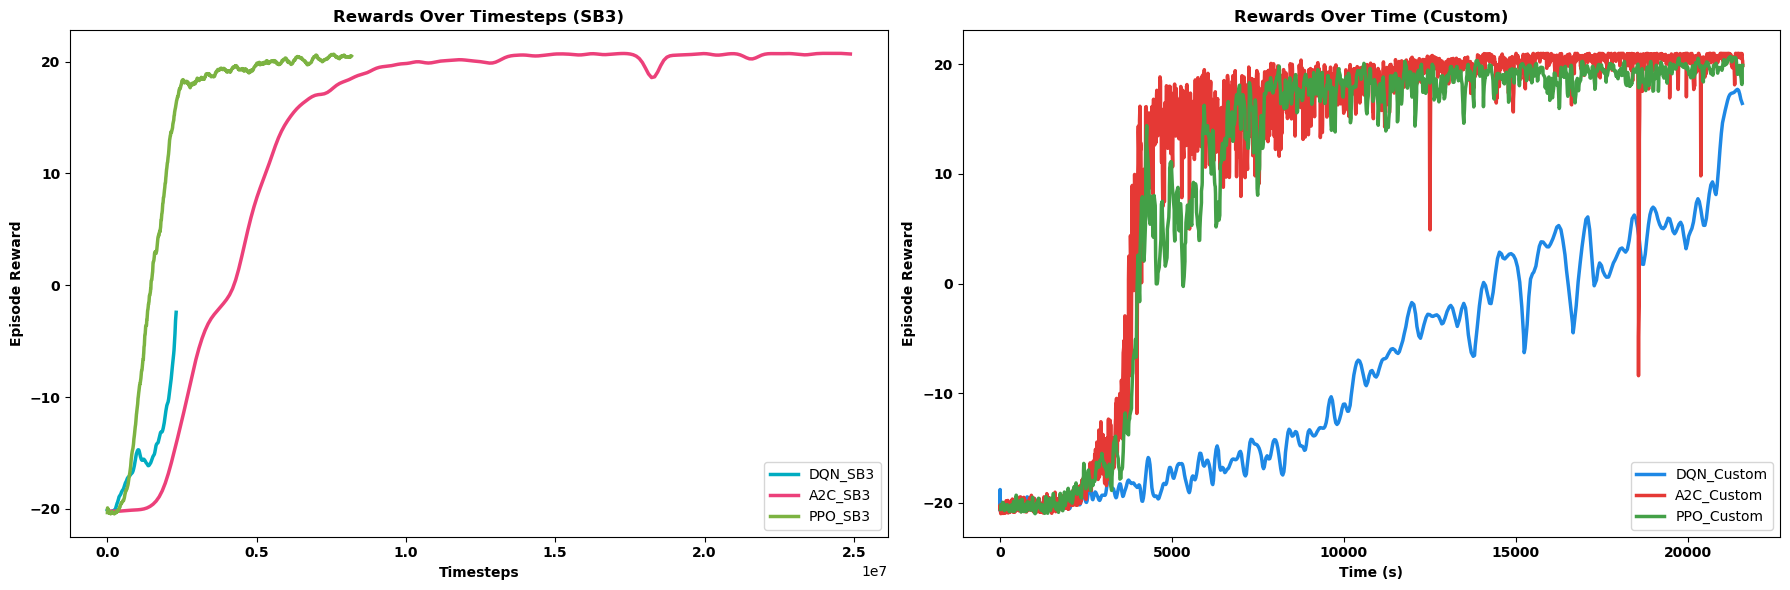

In [201]:

plot_rewards_comparison(data, sigma=2)

## Rewars over Episodes

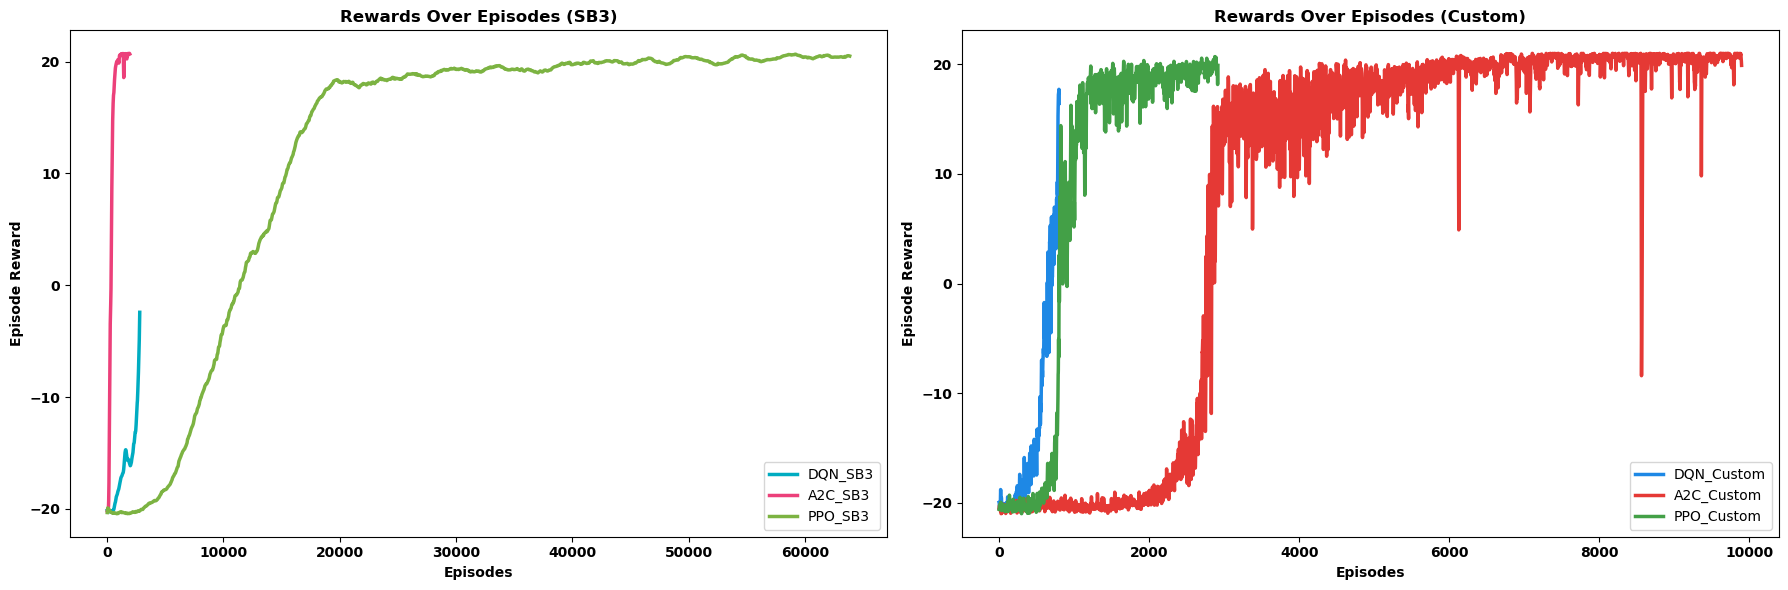

In [202]:

plot_rewards_over_episodes(data, sigma=2)

## SB3: Total Episodes, Total Timesteps, Mean Evaluation Reward, Training Stability and Rewards over Timesteps

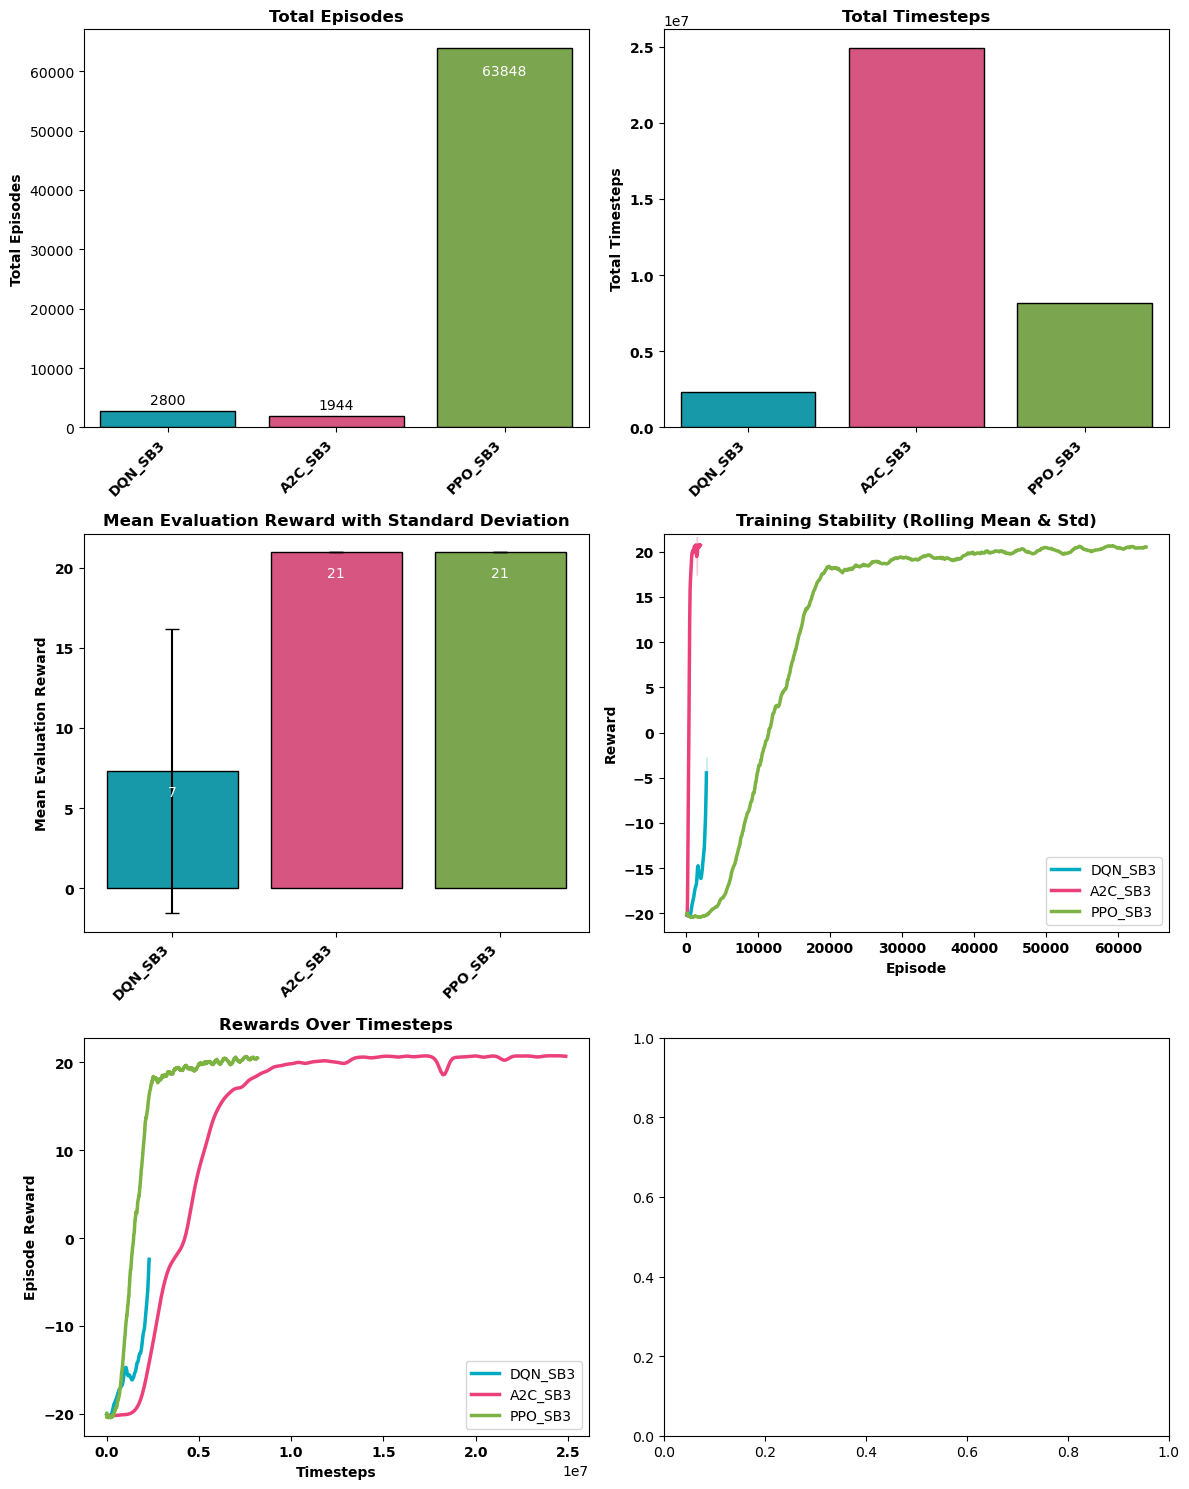

In [203]:
# Define the plotting functions to include
plot_functions = [
    plot_total_episodes, 
    plot_total_steps,   
    plot_mean_evaluation_rewards, 
]

plot_by_implementation = [
    plot_training_stability, 
    plot_rewards_over_time
]

# Plot comparisons in a grid for SB3 algorithms
plot_comparisons_in_grid(
    data,
    algorithms=[algo['name'] for algo in algorithms if algo['type'] == 'sb3'],
    plot_functions=plot_functions + plot_by_implementation,
    grid_size=(3, 2),
    thresholds=thresholds,
    sigma=2
)

## Custom: Total Episodes, Total Timesteps, Mean Evaluation Reward, Training Stability and Rewards over Timesteps

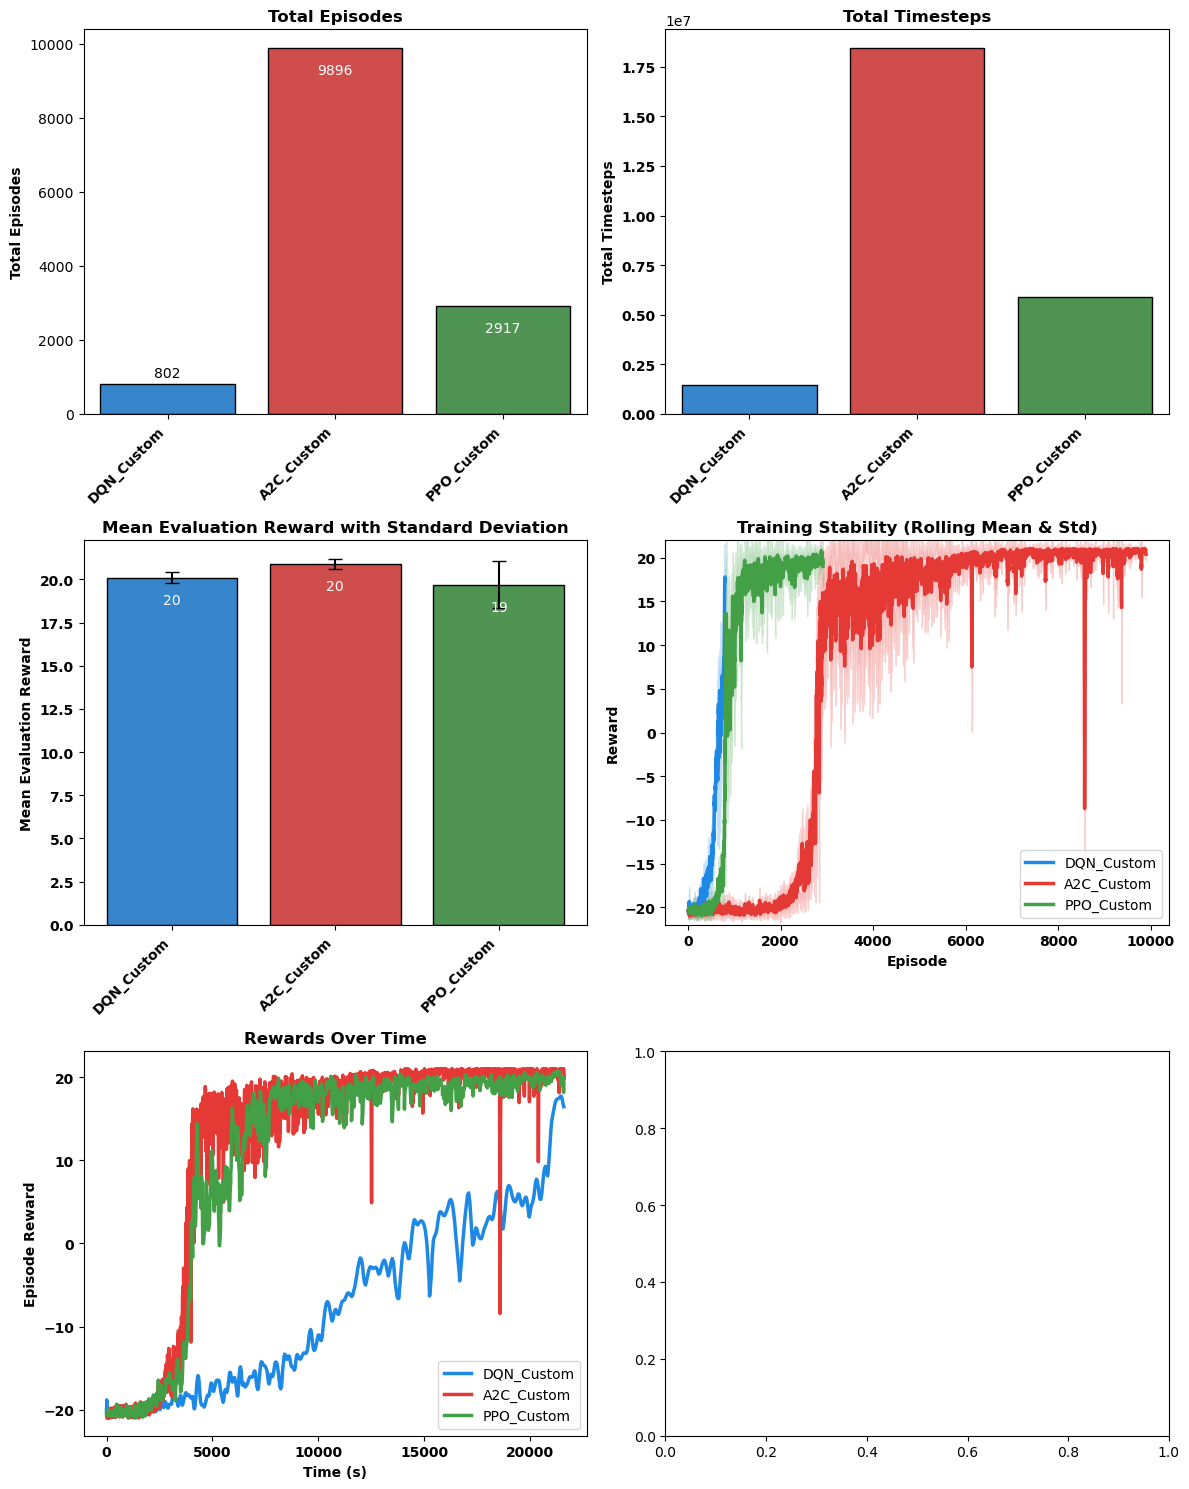

In [204]:

# Plot comparisons in a grid for Custom algorithms
plot_comparisons_in_grid(
    data,
    algorithms=[algo['name'] for algo in algorithms if algo['type'] == 'custom'],
    plot_functions=plot_functions + plot_by_implementation,
    grid_size=(3, 2),
    thresholds=thresholds,
    sigma=2
)

## Timesteps to Threshold

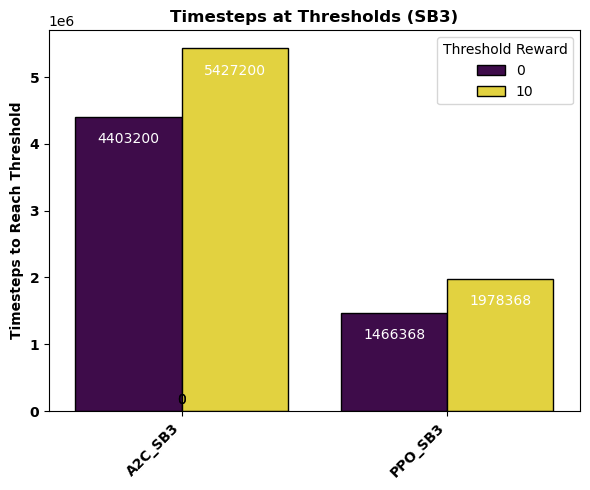

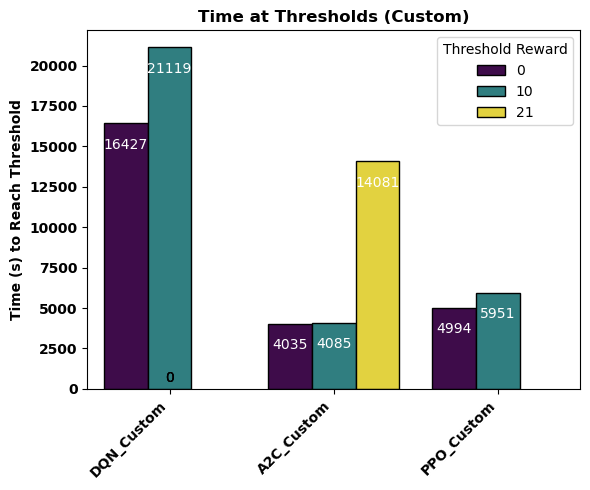

In [205]:
plot_comparisons_in_grid(
    data,
    algorithms=[algo['name'] for algo in algorithms if algo['type'] == 'sb3'],
    plot_functions=[plot_threshold_episodes_sb3],
    grid_size=(1, 1),
    thresholds=thresholds,
    sigma=2
)

plot_comparisons_in_grid(
    data,
    algorithms=[algo['name'] for algo in algorithms if algo['type'] == 'custom'],
    plot_functions=[plot_threshold_time_custom],
    grid_size=(1, 1),
    thresholds=thresholds,
    sigma=2
)